In [4]:
!pip install editdistance

  ERROR: Command errored out with exit status 1:
   command: /home/rodion/Projects/ai-journey-2020/.venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-0ogesmmt/editdistance/setup.py'"'"'; __file__='"'"'/tmp/pip-install-0ogesmmt/editdistance/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-igmka6eu
       cwd: /tmp/pip-install-0ogesmmt/editdistance/
  Complete output (76 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.8
  creating build/lib.linux-x86_64-3.8/editdistance
  copying editdistance/__init__.py -> build/lib.linux-x86_64-3.8/editdistance
  copying editdistance/_editdistance.h -> build/lib.linux-x86_64-3.8/editdistance
  copying editdistance/def.h -> build/lib.linux-x86_64-3.8/editdistance
  running build_ext
  bui

Failed to build editdistance
    Running setup.py install for editdistance ... error
    ERROR: Command errored out with exit status 1:
     command: /home/rodion/Projects/ai-journey-2020/.venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-0ogesmmt/editdistance/setup.py'"'"'; __file__='"'"'/tmp/pip-install-0ogesmmt/editdistance/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-_0tum404/install-record.txt --single-version-externally-managed --compile --install-headers /home/rodion/Projects/ai-journey-2020/.venv/include/site/python3.8/editdistance
         cwd: /tmp/pip-install-0ogesmmt/editdistance/
    Complete output (76 lines):
    running install
    running build
    running build_py
    creating build
    creating build/lib.linux-x86_64-3.8
    creating build/lib.linux-x86_64-3.8/edi

In [5]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt
import tqdm
from os.path import join
from collections import Counter
import re 
import io
import copy
import shutil
from tensorflow.keras import layers
# import editdistance

import os

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, LSTM,GRU, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [7]:
import tensorflow.keras as keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

TensorFlow version: 2.3.1
Keras version: 2.4.0


**Укажем пути для изображений и текста.**

In [14]:
#В этой папке лежат txt файлы перевода
trans_dir = '../data/train/words'
#В этой папке лежат  jpg файлы изображений
image_dir = '../data/train/images'

print(len(os.listdir(trans_dir)))

6196


Посмотрим на отдельное изображение.

In [15]:
example = os.listdir(image_dir)[0]

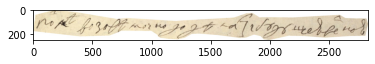

In [16]:
img = plt.imread(image_dir+'/'+example)
plt.imshow(img)
plt.show()

И его перевод.

In [17]:
with io.open(trans_dir+'/'+example[:-3]+'txt', 'r',  encoding='utf8') as file:
    data = file.read()

print(data)

послѣ в озовѣ мочно додѣлат] i будущею весною


В текстах встречаются слова, содержащие английские символы.

Но так как английских символов в целом не очень много, то из train-выборки можно удалить строки с ними (и обучаться только на оставшихся строках). Так мы и сделаем в текущем бейзлайне. Это сократит алфавит (и, как следствие, избавит нас от лишней шумности). 

При этом надо понимать, что в тестовой выборке английские символы, скорее всего, будут присутствовать. Поэтому будут и вынужденные ошибки, связанные с нашей вольной фильтрацией обучающей выборки.

Впрочем, метод распознавания всегда выбираете вы сами. 

Кроме того, советуем внимательно изучить train-выборку глазами.

In [7]:
english = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'm', 'n' ,'o', 'p', 'r', 's', 't', 'u', 'w']

In [8]:
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

Следующая функция подготавливает лэйблы, то есть переведенный текст. Как уже было сказано, игнорируются примеры, содержащие английские буквы.

In [9]:
def process_texts(image_dir,trans_dir):
    lens = []
    include_english = 0
    letters = ''

    lines = []
    names = []
    
    all_files = os.listdir(trans_dir)
    for filename in os.listdir(image_dir):
        if filename[:-3]+'txt' in all_files:
            name, ext = os.path.splitext(filename)
            txt_filepath = join(trans_dir, name + '.txt')
            with open(txt_filepath, 'r') as file:
                data = file.read()
                if len(data)==0:
                    continue
                if len(set(data).intersection(english))>0:
                    continue

                lines.append(data)
                names.append(filename)
                lens.append(len(data))
                letters += data
    print('Максимальная длина строки:', max(Counter(lens).keys()))
    print('Количество строк с английскими буквами ',include_english)

    return names,lines,Counter(letters)

В итоге мы получаем список изображений, соответствующий ему обработанный список строк и словарь символов.

In [10]:
names,lines,cnt = process_texts(image_dir,trans_dir)

Максимальная длина строки: 71
Количество строк с английскими буквами  0


In [11]:
letters = set(cnt.keys())

letters = sorted(list(letters))
print('Символы train:', ' '.join(letters))

Символы train:   ) + / 0 1 2 3 4 5 6 7 8 9 [ ] i k l | × ǂ а б в г д е ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я і ѣ – … ⊕ ⊗


Следующая функция подгружает изображения, меняет их до необходимого размера и нормирует.

In [12]:
def process_image(img):
    w, h,_ = img.shape
    
    new_w = 128
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h,_ = img.shape
    
    img = img.astype('float32')
    
    if w < 128:
        add_zeros = np.full((128-w, h,3), 255)
        img = np.concatenate((img, add_zeros))
        w, h,_ = img.shape
    
    if h < 1024:
        add_zeros = np.full((w, 1024-h,3), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h,_ = img.shape
        
    if h > 1024 or w > 128:
        dim = (1024,128)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)

    img = img / 255
    
    return img

**Подготовим обучающие и валидационные данные.**

In [13]:
def generate_data(lines,names,image_dir):
    data_images = []
    data_labels = []
    data_input_length = []
    data_label_length = []
    data_original_text = []
    data_original_image = []
    
    max_label_len = 0
    for line, name in tqdm.tqdm_notebook(zip(lines,names)):
        img = cv2.imread(image_dir+'/'+name)
        original_image = copy.deepcopy(img)
        img = process_image(img)
        try:
            label = text_to_labels(line)
        except:
            print('bad_label')
            continue
        data_images.append(img)
        data_labels.append(label)
        data_input_length.append(255)
        data_label_length.append(len(line))
        data_original_text.append(line)
        data_original_image.append(original_image)
        
        if len(line) > max_label_len:
            max_label_len = len(line)
        
    return data_images, data_labels, data_input_length, data_label_length, \
            data_original_text, data_original_image, max_label_len

Создадим обучающую и валидационную выборки.

In [14]:
lines_train = []
names_train = []

lines_val = []
names_val = []


for num,(line, name) in enumerate(zip(lines,names)):
    if num % 15 == 0:
        lines_val.append(line)
        names_val.append(name)
    else:
        lines_train.append(line)
        names_train.append(name)

In [15]:
train_images, train_labels, train_input_length, train_label_length, train_original_text, train_original_image, \
        train_max_label_len = generate_data(lines_train, names_train, image_dir)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [16]:
val_images, val_labels, val_input_length, val_label_length, val_original_text, val_original_image, \
        val_max_label_len = generate_data(lines_val, names_val, image_dir)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [17]:
max_label_len = max(train_max_label_len,val_max_label_len)
print(max_label_len)

71


Выведем пару обработанных изображений с переводом.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


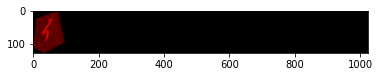

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


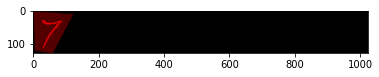

In [18]:
rnd = np.random.choice(range(len(train_images)),2)

for i in rnd:
    print(train_original_text[i])
    plt.imshow(train_images[i])
    plt.show()

**Дополним строки до максимальной длины**

In [19]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(letters))

val_padded_label = pad_sequences(val_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(letters))

In [20]:
train_padded_label.shape, val_padded_label.shape

((5698, 71), (407, 71))

In [21]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

val_images = np.asarray(val_images)
val_input_length = np.asarray(val_input_length)
val_label_length = np.asarray(val_label_length)

In [22]:
train_images.shape

(5698, 128, 1024, 3)

## **Строим модель**

Модель состоит из нескольких слоев CNN, GRU и использует ctc_loss. [Вот](https://www.youtube.com/watch?v=SAfJ6nP2rrI) хорошее видео о нем на русском.

In [23]:
inputs = Input(shape=(128,1024,3))

conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(4, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(4, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

pool_4 = MaxPool2D(pool_size=(4, 1),padding='same')(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(4, 1),padding='same')(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

blstm_1 = Bidirectional(GRU(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(GRU(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(letters)+1, activation = 'softmax')(blstm_2)
act_model = Model(inputs=inputs, outputs=outputs)
    
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [24]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 1024, 3)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 1024, 64)     1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 512, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 512, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 256, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 256, 256)      295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 256, 256)      590080

In [25]:
batch_size = 20
epochs = 300

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics=['accuracy'])

os.makedirs('checkpoint', exist_ok=True)

filepath="checkpoint/model.hdf5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=5, min_lr=0.00001)

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint,es,reduce_lr]

history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([val_images, val_padded_label, val_input_length, val_label_length], [np.zeros(len(val_images))]),
                    verbose=2,
                    callbacks=callbacks_list)


Посмотрим качество на валидации.

In [26]:
import time

In [27]:
start = time.time()
act_model.load_weights(filepath)
prediction = act_model.predict(val_images)

decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)
end = time.time()
print(end-start)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
9.308727264404297


In [28]:
numCharErr = 0
numCharTotal = 0
numStringOK = 0
numStringTotal = 0

word_eds, word_true_lens = [], []

print('Ground truth -> Recognized')	
for i in range(len(out)):
    pred = ''
    for p in out[i]:
        if int(p) != -1:
            pred+=letters[int(p)]
    true = val_original_text[i]
    
    numStringOK += 1 if true == pred else 0
    numStringTotal += 1
    dist = editdistance.eval(pred, true)
    numCharErr += dist
    numCharTotal += len(true)
    
    pred_words = pred.split()
    true_words = true.split()
    word_eds.append(editdistance.eval(pred_words, true_words))
    word_true_lens.append(len(true_words))
    
    print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + true + '"', '->', '"' + pred + '"')

charErrorRate = numCharErr / numCharTotal
wordErrorRate = sum(word_eds) / sum(word_true_lens) 
stringAccuracy = numStringOK / numStringTotal
print('Character error rate: %f%%. Word error rate: %f%%. String accuracy: %f%%.' % \
      (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0))

Ground truth -> Recognized
[ERR:6] "с воронежа пришел а другова зафтра" -> "своронежа пришел а друро вазаф тре"
[ERR:3] "на будет экадра чтоб не потерят людей" -> "на будет в каддра чтоб не потерят людей"
[ERR:1] "бусоф также гдѣ найдете i сколко" -> "бусоф также гдѣн найдете i сколко"
[ERR:3] "ного и возна в заключе" -> "ного а возна в закию че"
[ERR:1] "пространно отвѣтствовал вам господин" -> "пространно отвѣтствовал вам гонподин"
[ERR:45] "+ i чтоб оныя короче не были 130 фут [дабы могли" -> "+ к"
[OK] "учинит] i тѣм лутчюю выгоду" -> "учинит] i тѣм лутчюю выгоду"
[ERR:1] "не сумневаемся что на" -> "не сум неваемся что на"
[ERR:4] "обувей i протъчево" -> "обувет i проть чевъ"
[ERR:2] "во флотѣ для дѣйствъ про" -> "вофлотѣ для дѣйство про"
[ERR:2] "ца i по пунктам дѣлат здѣс ново" -> "ца i по пункам дѣлат здѣсново"
[OK] "2" -> "2"
[ERR:2] "же пишете что голстенцы каковы были про" -> "же пишете что голстетцы каковыбыли про"
[OK] "что вершка два iли три пот судном то" -> "что вершка д

**Загружаем тестовые изображения, делаем предсказания и записываем их в файл.**

Этот ноутбук - публичный бейзлайн. Тестовая выборка будет автоматически подкладываться в образ, куда участник загрузит модель. Поэтому сейчас следующие строчки закомменчены. И пример запуска модели и записи предсказаний в файл будет проведен на валидационных изображениях.

In [37]:
#Для примера работы запуска модели и записи в файл, пусть валидация станет тестовыми изображениями
test_images = val_images

In [38]:
#test_image_dir = 'test/images'

In [39]:
# test_images = []

# for name in  os.listdir(test_image_dir):
#     img = cv2.imread(test_image_dir+'/'+name)
#     img = process_image(img)
#     test_images.append(img)
# test_images = np.asarray(test_images)

In [40]:
start = time.time()

prediction =act_model.predict(test_images)
 
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

prediction = []
for i, x in enumerate(out):
    pred = ''
    for p in x:
        if int(p) != -1:
            pred+=letters[int(p)]
            
    prediction.append(pred)
end = time.time()
print(end - start)

2.049828052520752


In [41]:
len(prediction)

407

In [42]:
file = open("pred.txt", "w")
for num,line in enumerate(prediction):
    file.write(line)
    if num+1!=len(prediction):
        file.write("\n")
file.close()